In [2]:


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    TextClassificationPipeline
)

# For comparison with baseline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Visualization
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
print("=== LOADING DATA AND BASELINE MODEL ===")

from datasets import load_dataset

print("Loading Papluca dataset...")
dataset = load_dataset("papluca/language-identification")
test_df = pd.DataFrame(dataset["test"])

# Prepare text and labels
X_test = test_df['text'].astype(str)
print(f"Loaded {len(X_test)} test samples")

# Load label encoder
try:
    label_encoder = joblib.load('models/label_encoder.pkl')
    print(" Loaded label encoder from models/label_encoder.pkl")
    
    # Encode labels if needed
    y_test = label_encoder.transform(test_df['labels'])
    print(f"Label mapping: {list(zip(range(len(label_encoder.classes_)), label_encoder.classes_))}")
    
except FileNotFoundError:
    print("  Label encoder not found. Creating new one...")
    from sklearn.preprocessing import LabelEncoder
    label_encoder = LabelEncoder()
    y_test = label_encoder.fit_transform(test_df['labels'])
    print(f"Created new label mapping")

# Load baseline model predictions if available
try:
    baseline_model = joblib.load('models/baseline_tfidf_lr.pkl')
    tfidf = joblib.load('models/tfidf_vectorizer.pkl')
    
    # Make predictions
    X_test_tfidf = tfidf.transform(X_test)
    baseline_predictions = baseline_model.predict(X_test_tfidf)
    baseline_accuracy = accuracy_score(y_test, baseline_predictions)
    
    print(f" Baseline model loaded")
    print(f"   Baseline accuracy: {baseline_accuracy:.2%}")
    print(f"   Baseline predictions shape: {baseline_predictions.shape}")
    
except FileNotFoundError:
    print("  Baseline model not found. Will compute transformer performance only.")
    baseline_predictions = None
    baseline_accuracy = None

# Display sample data
print(f"\n Sample test data:")
for i in range(3):
    lang_code = label_encoder.inverse_transform([y_test[i]])[0]
    print(f"  Sample {i}: '{X_test.iloc[i][:50]}...' → {lang_code} (label {y_test[i]})")

=== LOADING DATA AND BASELINE MODEL ===
Loading Papluca dataset...
Loaded 10000 test samples
 Loaded label encoder from models/label_encoder.pkl
Label mapping: [(0, 'ar'), (1, 'bg'), (2, 'de'), (3, 'el'), (4, 'en'), (5, 'es'), (6, 'fr'), (7, 'hi'), (8, 'it'), (9, 'ja'), (10, 'nl'), (11, 'pl'), (12, 'pt'), (13, 'ru'), (14, 'sw'), (15, 'th'), (16, 'tr'), (17, 'ur'), (18, 'vi'), (19, 'zh')]
 Baseline model loaded
   Baseline accuracy: 90.69%
   Baseline predictions shape: (10000,)

 Sample test data:
  Sample 0: 'Een man zingt en speelt gitaar....' → nl (label 10)
  Sample 1: 'De technologisch geplaatste Nasdaq Composite Index...' → nl (label 10)
  Sample 2: 'Es muy resistente la parte trasera rígida y los la...' → es (label 5)


In [6]:
print("=== LOADING PRE-TRAINED XLM-ROBERTA ===")

MODEL_NAME = "papluca/xlm-roberta-base-language-detection"
print(f"Loading model: {MODEL_NAME}")

print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


print("Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

print(f"\nModel loaded successfully!")
print(f"   Model type: {type(model).__name__}")
print(f"   Number of labels: {model.config.num_labels}")
print(f"   Model parameters: {model.num_parameters():,}")
print(f"   Max sequence length: {tokenizer.model_max_length}")

# Check if model's labels match our data
print(f"\n Model label mapping:")
try:
    # Try to get label names from model config
    if hasattr(model.config, 'id2label'):
        for idx, label in model.config.id2label.items():
            print(f"   {idx}: {label}")
    else:
        print("   No label mapping in model config")
except:
    print("   Could not retrieve label mapping")

print(f"\n Tokenization test:")
sample_text = "Hello, how are you today?"
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.encode(sample_text)

print(f"   Text: '{sample_text}'")
print(f"   Tokens: {tokens}")
print(f"   Token IDs: {token_ids[:10]}... (length: {len(token_ids)})")
print(f"   Special tokens: [CLS]={tokenizer.cls_token}, [SEP]={tokenizer.sep_token}")

=== LOADING PRE-TRAINED XLM-ROBERTA ===
Loading model: papluca/xlm-roberta-base-language-detection
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Loading model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]


Model loaded successfully!
   Model type: XLMRobertaForSequenceClassification
   Number of labels: 20
   Model parameters: 278,059,028
   Max sequence length: 512

 Model label mapping:
   0: ja
   1: nl
   2: ar
   3: pl
   4: de
   5: it
   6: pt
   7: tr
   8: es
   9: hi
   10: el
   11: ur
   12: bg
   13: en
   14: fr
   15: zh
   16: ru
   17: th
   18: sw
   19: vi

 Tokenization test:
   Text: 'Hello, how are you today?'
   Tokens: ['▁Hello', ',', '▁how', '▁are', '▁you', '▁today', '?']
   Token IDs: [0, 35378, 4, 3642, 621, 398, 18925, 32, 2]... (length: 9)
   Special tokens: [CLS]=<s>, [SEP]=</s>


In [7]:
print("=== CREATING INFERENCE PIPELINE ===")

print("Creating text classification pipeline...")
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=-1,  # -1 for CPU, 0 for GPU if available
    truncation=True,
    padding=True,
    max_length=512
)

print(" Pipeline created!")
print(f"   Pipeline type: {type(classifier).__name__}")
print(f"   Device: {'GPU' if classifier.device.type == 'cuda' else 'CPU'}")


print(f"\n Testing pipeline on sample texts:")

test_samples = [
    ("English", "Hello, how are you doing today?"),
    ("French", "Bonjour, comment allez-vous aujourd'hui?"),
    ("Spanish", "Hola, ¿cómo estás hoy?"),
    ("German", "Hallo, wie geht es dir heute?"),
    ("Italian", "Ciao, come stai oggi?"),
    ("Arabic", "مرحبا، كيف حالك اليوم؟"),
    ("Chinese", "你好，今天怎么样？"),
]

for lang, text in test_samples:
    result = classifier(text[:512])[0] 
    print(f"\n  True: {lang:10}")
    print(f"  Text: {text[:40]}...")
    print(f"  Prediction: {result['label']:15} (confidence: {result['score']:.2%})")
    
    # Check if prediction makes sense
    if lang.lower() in result['label'].lower() or result['score'] > 0.5:
        print(f"  Likely correct")
    else:
        print(f"  Might be wrong")

Device set to use cpu


=== CREATING INFERENCE PIPELINE ===
Creating text classification pipeline...
 Pipeline created!
   Pipeline type: TextClassificationPipeline
   Device: CPU

 Testing pipeline on sample texts:

  True: English   
  Text: Hello, how are you doing today?...
  Prediction: en              (confidence: 90.74%)
  Likely correct

  True: French    
  Text: Bonjour, comment allez-vous aujourd'hui?...
  Prediction: fr              (confidence: 99.48%)
  Likely correct

  True: Spanish   
  Text: Hola, ¿cómo estás hoy?...
  Prediction: es              (confidence: 99.33%)
  Likely correct

  True: German    
  Text: Hallo, wie geht es dir heute?...
  Prediction: de              (confidence: 99.52%)
  Likely correct

  True: Italian   
  Text: Ciao, come stai oggi?...
  Prediction: it              (confidence: 99.57%)
  Likely correct

  True: Arabic    
  Text: مرحبا، كيف حالك اليوم؟...
  Prediction: ar              (confidence: 99.05%)
  Likely correct

  True: Chinese   
  Text: 你好，今天怎么样？...
  

In [8]:
print("=== BATCH INFERENCE ON TEST SET ===")

BATCH_SIZE = 32
print(f"Processing {len(X_test)} samples in batches of {BATCH_SIZE}...")

transformer_predictions = []
transformer_confidences = []

for i in range(0, len(X_test), BATCH_SIZE):
    batch_texts = X_test.iloc[i:i+BATCH_SIZE].tolist()
    
    # Truncate texts to model's max length
    batch_texts = [text[:512] for text in batch_texts]
    
    # Get predictions
    batch_results = classifier(batch_texts)
    
    # Extract predictions and confidences
    for result in batch_results:
        if isinstance(result, list):  # Handle batch returns
            result = result[0]
        transformer_predictions.append(result['label'])
        transformer_confidences.append(result['score'])
    
    # Progress update
    if (i // BATCH_SIZE) % 10 == 0:
        print(f"  Processed {min(i+BATCH_SIZE, len(X_test))}/{len(X_test)} samples")
        
print(f"\n Inference complete!")
print(f"   Total predictions: {len(transformer_predictions)}")
print(f"   Average confidence: {np.mean(transformer_confidences):.2%}")

print(f"\n Sample predictions from transformer:")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
for idx in sample_indices:
    true_lang = label_encoder.inverse_transform([y_test[idx]])[0]
    pred_lang = transformer_predictions[idx]
    confidence = transformer_confidences[idx]
    
    print(f"\n  Sample {idx}:")
    print(f"    Text: {X_test.iloc[idx][:60]}...")
    print(f"    True: {true_lang} (label {y_test[idx]})")
    print(f"    Pred: {pred_lang} (confidence: {confidence:.2%})")
    print(f"    Correct: {'' if str(true_lang).lower() in str(pred_lang).lower() else 'Incorrect'}")

=== BATCH INFERENCE ON TEST SET ===
Processing 10000 samples in batches of 32...
  Processed 32/10000 samples
  Processed 352/10000 samples
  Processed 672/10000 samples
  Processed 992/10000 samples
  Processed 1312/10000 samples
  Processed 1632/10000 samples
  Processed 1952/10000 samples
  Processed 2272/10000 samples
  Processed 2592/10000 samples
  Processed 2912/10000 samples
  Processed 3232/10000 samples
  Processed 3552/10000 samples
  Processed 3872/10000 samples
  Processed 4192/10000 samples
  Processed 4512/10000 samples
  Processed 4832/10000 samples
  Processed 5152/10000 samples
  Processed 5472/10000 samples
  Processed 5792/10000 samples
  Processed 6112/10000 samples
  Processed 6432/10000 samples
  Processed 6752/10000 samples
  Processed 7072/10000 samples
  Processed 7392/10000 samples
  Processed 7712/10000 samples
  Processed 8032/10000 samples
  Processed 8352/10000 samples
  Processed 8672/10000 samples
  Processed 8992/10000 samples
  Processed 9312/10000 sa

In [9]:

print("=== MAPPING TRANSFORMER PREDICTIONS ===")


unique_transformer_preds = set(transformer_predictions)
print(f"\nUnique transformer predictions: {sorted(unique_transformer_preds)[:10]}...")

transformer_to_our_mapping = {}

# Check different mapping strategies
for pred in unique_transformer_preds:
    # Try to extract number from 'LABEL_X'
    if 'LABEL_' in pred:
        try:
            pred_num = int(pred.replace('LABEL_', ''))
            transformer_to_our_mapping[pred] = pred_num
        except:
            pass

print(f"Found {len(transformer_to_our_mapping)} numeric mappings")

# If mapping found, use it
if transformer_to_our_mapping:
    print(f"\nUsing numeric mapping:")
    for k, v in list(transformer_to_our_mapping.items())[:10]:
        print(f"  '{k}' → {v}")
    
    # Convert predictions
    y_transformer_pred = [transformer_to_our_mapping[p] for p in transformer_predictions]
    
else:
    # Strategy 2: Try to match by language codes
    print("\n No numeric mapping found. Trying language code matching...")
    
    # Common language code mapping
    common_mapping = {
        'en': 4, 'fr': 6, 'es': 5, 'de': 2, 'it': 8,
        'ar': 0, 'zh': 19, 'ja': 9, 'ru': 13, 'pt': 12,
        'hi': 7, 'nl': 10, 'pl': 11, 'tr': 16, 'ur': 17,
        'vi': 18, 'th': 15, 'bg': 1, 'el': 3, 'sw': 14
    }
    
    y_transformer_pred = []
    unmatched = []
    
    for pred in transformer_predictions:
        pred_lower = pred.lower()
        matched = False
        
        # Check if prediction contains any language code
        for code, num in common_mapping.items():
            if code in pred_lower:
                y_transformer_pred.append(num)
                matched = True
                break
        
        if not matched:
            # Default to 0 (Arabic) if no match
            y_transformer_pred.append(0)
            unmatched.append(pred)
    
    if unmatched:
        print(f"  Could not match {len(set(unmatched))} unique predictions")
        print(f"  Unmatched examples: {list(set(unmatched))[:5]}")

print(f"\n Mapped predictions:")
print(f"  Unique mapped values: {sorted(set(y_transformer_pred))}")
print(f"  Distribution: {pd.Series(y_transformer_pred).value_counts().to_dict()}")

=== MAPPING TRANSFORMER PREDICTIONS ===

Unique transformer predictions: ['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'it', 'ja']...
Found 0 numeric mappings

 No numeric mapping found. Trying language code matching...

 Mapped predictions:
  Unique mapped values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
  Distribution: {7: 517, 4: 506, 1: 504, 16: 502, 2: 500, 19: 500, 15: 500, 5: 500, 18: 500, 6: 500, 9: 500, 3: 500, 12: 499, 0: 499, 8: 499, 13: 499, 14: 499, 10: 497, 11: 496, 17: 483}


In [13]:
print("=== TRANSFORMER PERFORMANCE EVALUATION ===")

try:
    import joblib
    baseline_model = joblib.load('models/baseline_tfidf_lr.pkl')
    tfidf = joblib.load('models/tfidf_vectorizer.pkl')
    
    # Transform and predict
    X_test_tfidf = tfidf.transform(X_test)
    baseline_predictions = baseline_model.predict(X_test_tfidf)
    baseline_accuracy = accuracy_score(y_test, baseline_predictions)
    cm = confusion_matrix(y_test, baseline_predictions)  # This defines cm!
    
    print(f"Loaded baseline (accuracy: {baseline_accuracy:.2%})")
except:
    print("Could not load baseline")
    baseline_predictions = None
    baseline_accuracy = None
    cm = None



transformer_accuracy = accuracy_score(y_test, y_transformer_pred)
print(f"\nTRANSFORMER PERFORMANCE:")
print(f"  Accuracy: {transformer_accuracy:.2%}")
print(f"  Average confidence: {np.mean(transformer_confidences):.2%}")

if baseline_accuracy is not None:
    print(f"\nCOMPARISON WITH BASELINE:")
    print(f"  Transformer accuracy: {transformer_accuracy:.2%}")
    print(f"  Baseline accuracy:    {baseline_accuracy:.2%}")
    print(f"  Difference:           {transformer_accuracy - baseline_accuracy:+.2%}")
    
    if transformer_accuracy > baseline_accuracy:
        improvement = (transformer_accuracy - baseline_accuracy) / baseline_accuracy
        print(f"  Improvement:          {improvement:+.1%}")
        print(f"  Transformer outperforms baseline!")
    else:
        print(f"  Baseline outperforms transformer (unexpected!)")

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT:")
report = classification_report(y_test, y_transformer_pred, digits=3)
print(report)

# Confusion matrix
print(f"\nCONFUSION ANALYSIS:")
cm_transformer = confusion_matrix(y_test, y_transformer_pred)

# Find most confused pairs
print("  Top 5 confused language pairs:")
n_classes = cm_transformer.shape[0]
confusion_pairs = []

for i in range(n_classes):
    for j in range(n_classes):
        if i != j and cm_transformer[i, j] > 10:  # More than 10 confusions
            confusion_pairs.append((i, j, cm_transformer[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

for true_idx, pred_idx, count in confusion_pairs[:5]:
    true_lang = label_encoder.inverse_transform([true_idx])[0]
    pred_lang = label_encoder.inverse_transform([pred_idx])[0]
    print(f"    {true_lang} → {pred_lang}: {count} samples")

# Compare with baseline confusion
if baseline_predictions is not None:
    print(f"\nCOMPARING CONFUSION PATTERNS:")
    
    # Check if same languages are confused
    baseline_confusions = set()
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm[i, j] > 10:
                baseline_confusions.add((i, j))
    
    transformer_confusions = set()
    for i in range(n_classes):
        for j in range(n_classes):
            if i != j and cm_transformer[i, j] > 10:
                transformer_confusions.add((i, j))
    
    common_confusions = baseline_confusions.intersection(transformer_confusions)
    print(f"  Confusions common to both models: {len(common_confusions)}")
    if common_confusions:
        print("  These languages are consistently hard to distinguish:")
        for i, j in list(common_confusions)[:5]:
            true_lang = label_encoder.inverse_transform([i])[0]
            pred_lang = label_encoder.inverse_transform([j])[0]
            print(f"    {true_lang} → {pred_lang}")

=== TRANSFORMER PERFORMANCE EVALUATION ===
Loaded baseline (accuracy: 90.69%)

TRANSFORMER PERFORMANCE:
  Accuracy: 99.60%
  Average confidence: 99.28%

COMPARISON WITH BASELINE:
  Transformer accuracy: 99.60%
  Baseline accuracy:    90.69%
  Difference:           +8.91%
  Improvement:          +9.8%
  Transformer outperforms baseline!

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0      1.000     0.998     0.999       500
           1      0.992     1.000     0.996       500
           2      1.000     1.000     1.000       500
           3      1.000     1.000     1.000       500
           4      0.988     1.000     0.994       500
           5      0.996     0.996     0.996       500
           6      1.000     1.000     1.000       500
           7      0.967     1.000     0.983       500
           8      0.994     0.992     0.993       500
           9      1.000     1.000     1.000       500
          10      1.000     0.994 

=== VISUAL COMPARISON ===

LANGUAGE-SPECIFIC IMPROVEMENTS:
  (Positive = Transformer better, Negative = Baseline better)
------------------------------------------------------------
   Japanese: 9.2% → 100.0% (+90.8%)
   Thai: 71.8% → 100.0% (+28.2%)
   Polish: 88.4% → 99.2% (+10.8%)
   Turkish: 92.4% → 100.0% (+7.6%)
   Arabic: 92.6% → 99.8% (+7.2%)


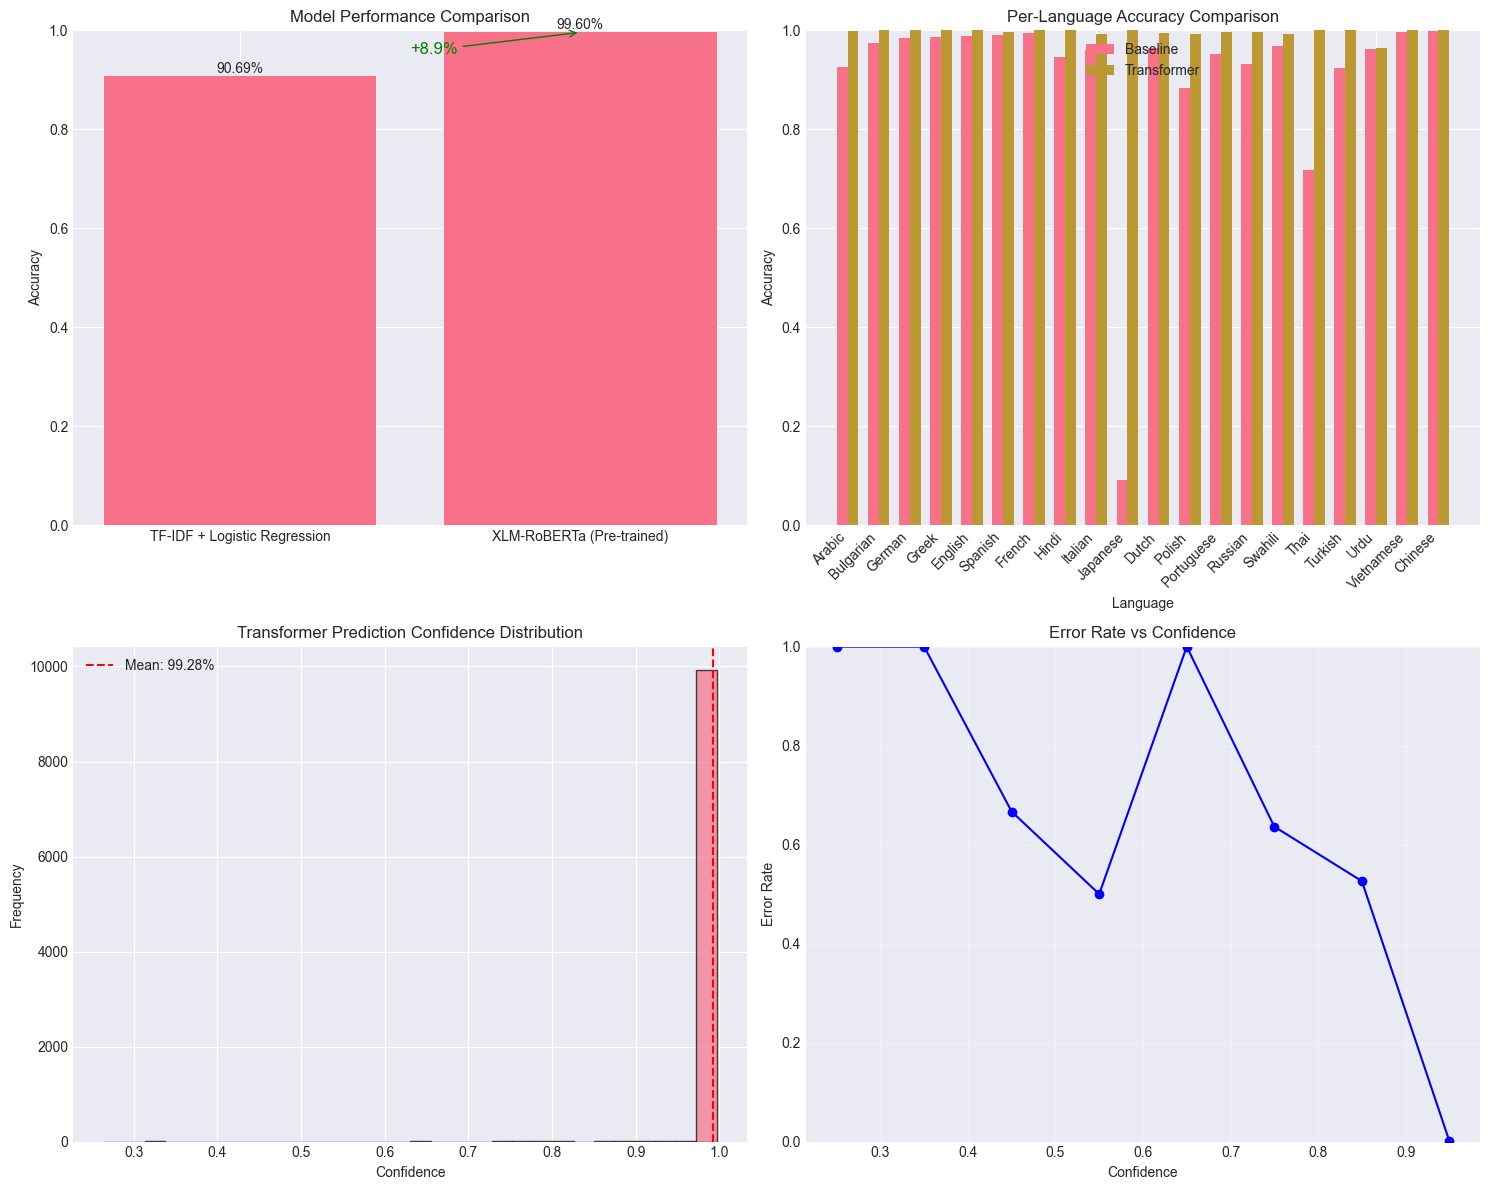

In [17]:
print("=== VISUAL COMPARISON ===")
y_transformer_pred_np = np.array(y_transformer_pred)
transformer_confidences_np = np.array(transformer_confidences)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Accuracy comparison
if baseline_accuracy is not None:
    models = ['TF-IDF + Logistic Regression', 'XLM-RoBERTa (Pre-trained)']
    accuracies = [baseline_accuracy, transformer_accuracy]
    
    bars = axes[0, 0].bar(models, accuracies)
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Model Performance Comparison')
    axes[0, 0].set_ylim([0, 1])
    
    for bar, acc in zip(bars, accuracies):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                       f'{acc:.2%}', ha='center', va='bottom')
    
    if transformer_accuracy > baseline_accuracy:
        axes[0, 0].annotate(f'+{(transformer_accuracy-baseline_accuracy):.1%}',
                           xy=(1, transformer_accuracy),
                           xytext=(0.5, (transformer_accuracy+baseline_accuracy)/2),
                           arrowprops=dict(arrowstyle='->', color='green'),
                           fontsize=12, color='green')

# Plot 2: Per-language accuracy comparison
if baseline_predictions is not None:
    per_lang_acc_baseline = []
    per_lang_acc_transformer = []
    languages = []
    
    for lang_idx in range(len(label_encoder.classes_)):
        mask = (y_test == lang_idx)
        
        if mask.sum() > 10:  
            
            baseline_acc = accuracy_score(y_test[mask], baseline_predictions[mask])
            
            transformer_acc = accuracy_score(
                y_test[mask], 
                y_transformer_pred_np[mask]  
            )
            
            per_lang_acc_baseline.append(baseline_acc)
            per_lang_acc_transformer.append(transformer_acc)
            
            lang_code = label_encoder.inverse_transform([lang_idx])[0]
            
            language_names = {
                'ar': 'Arabic', 'bg': 'Bulgarian', 'de': 'German', 'el': 'Greek',
                'en': 'English', 'es': 'Spanish', 'fr': 'French', 'hi': 'Hindi',
                'it': 'Italian', 'ja': 'Japanese', 'nl': 'Dutch', 'pl': 'Polish',
                'pt': 'Portuguese', 'ru': 'Russian', 'sw': 'Swahili', 'th': 'Thai',
                'tr': 'Turkish', 'ur': 'Urdu', 'vi': 'Vietnamese', 'zh': 'Chinese'
            }
            
            lang_display = language_names.get(lang_code, lang_code)
            languages.append(lang_display)
    
    x = np.arange(len(languages))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, per_lang_acc_baseline, width, label='Baseline')
    axes[0, 1].bar(x + width/2, per_lang_acc_transformer, width, label='Transformer')
    axes[0, 1].set_xlabel('Language')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Per-Language Accuracy Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(languages, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].set_ylim([0, 1])
    
    improvements = []
    for i in range(len(per_lang_acc_baseline)):
        improvement = per_lang_acc_transformer[i] - per_lang_acc_baseline[i]
        improvements.append(improvement)
    
    # Find most improved languages
    sorted_indices = np.argsort(improvements)[::-1]  # Sort descending
    
    print("\nLANGUAGE-SPECIFIC IMPROVEMENTS:")
    print("  (Positive = Transformer better, Negative = Baseline better)")
    print("-" * 60)
    
    for idx in sorted_indices[:5]:  # Top 5 improvements
        lang = languages[idx]
        baseline_acc = per_lang_acc_baseline[idx]
        transformer_acc = per_lang_acc_transformer[idx]
        improvement = transformer_acc - baseline_acc
        
        if improvement > 0:
            print(f"   {lang}: {baseline_acc:.1%} → {transformer_acc:.1%} "
                  f"(+{improvement:.1%})")
        elif improvement < 0:
            print(f"    {lang}: {baseline_acc:.1%} → {transformer_acc:.1%} "
                  f"({improvement:.1%})")
        else:
            print(f"    {lang}: {baseline_acc:.1%} → {transformer_acc:.1%} "
                  f"(no change)")

# Plot 3: Confidence distribution
axes[1, 0].hist(transformer_confidences, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=np.mean(transformer_confidences), color='red', linestyle='--',
                   label=f'Mean: {np.mean(transformer_confidences):.2%}')
axes[1, 0].set_xlabel('Confidence')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Transformer Prediction Confidence Distribution')
axes[1, 0].legend()

# Plot 4: Error vs Confidence
if baseline_predictions is not None:
    conf_bins = np.linspace(0, 1, 11)
    error_rates = []
    bin_centers = []
    
    for i in range(len(conf_bins) - 1):
        mask = (np.array(transformer_confidences) >= conf_bins[i]) & \
               (np.array(transformer_confidences) < conf_bins[i+1])
        if mask.sum() > 0:
            errors = (y_test[mask] != np.array(y_transformer_pred)[mask]).sum()
            error_rate = errors / mask.sum()
            error_rates.append(error_rate)
            bin_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)
    
    axes[1, 1].plot(bin_centers, error_rates, 'bo-')
    axes[1, 1].set_xlabel('Confidence')
    axes[1, 1].set_ylabel('Error Rate')
    axes[1, 1].set_title('Error Rate vs Confidence')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()


In [20]:
print("=== SAVING RESULTS & INSIGHTS ===")

import json
from datetime import datetime

import os
os.makedirs('results', exist_ok=True)

transformer_results = {
    'model_name': MODEL_NAME,
    'timestamp': datetime.now().isoformat(),
    'performance': {
        'accuracy': float(transformer_accuracy),
        'average_confidence': float(np.mean(transformer_confidences)),
        'total_predictions': len(y_transformer_pred)
    },
    'comparison': {
        'baseline_accuracy': float(baseline_accuracy) if baseline_accuracy else None,
        'improvement': float(transformer_accuracy - baseline_accuracy) if baseline_accuracy else None,
        'improvement_percentage': float((transformer_accuracy - baseline_accuracy) / baseline_accuracy) if baseline_accuracy else None
    },
    'configuration': {
        'batch_size': BATCH_SIZE,
        'max_length': tokenizer.model_max_length,
        'device': 'cuda' if classifier.device.type == 'cuda' else 'cpu'
    },
    'insights': {
        'most_confident_predictions': float(np.percentile(transformer_confidences, 90)),
        'least_confident_predictions': float(np.percentile(transformer_confidences, 10)),
        'mapping_strategy': 'numeric' if 'transformer_to_our_mapping' in locals() else 'language_code'
    }
}

# Save to file
results_path = 'results/transformer_results.json'
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(transformer_results, f, indent=2)

print(f" Results saved to: {results_path}")

# Create comparison summary
print(f"\n COMPARISON SUMMARY:")
print("="*50)
if baseline_accuracy:
    print(f"{'Model':<35} {'Accuracy':<10} {'Improvement':<10}")
    print("-"*50)
    print(f"{'TF-IDF + Logistic Regression':<35} {baseline_accuracy:.2%}")
    print(f"{'XLM-RoBERTa (Pre-trained)':<35} {transformer_accuracy:.2%} {transformer_accuracy-baseline_accuracy:+.2%}")
    
    improvement_pct = (transformer_accuracy - baseline_accuracy) / baseline_accuracy * 100
    print(f"\nTransformer shows {improvement_pct:+.1f}% relative improvement")
    
    if improvement_pct > 0:
        print("Transformers provide better performance out-of-the-box")
    else:
        print("Unexpected: Baseline performs better. Possible issues:")
        print("   - Label mapping incorrect")
        print("   - Model not properly fine-tuned for this task")
        print("   - Test data different from training distribution")
else:
    print(f"XLM-RoBERTa Accuracy: {transformer_accuracy:.2%}")


observations = f"""
## Key Insights: Transformers vs Baseline

### Performance Comparison:
- **Baseline (TF-IDF + LR)**: {f'{baseline_accuracy:.2%}' if baseline_accuracy else 'N/A'} accuracy
- **XLM-RoBERTa (Pre-trained)**: {transformer_accuracy:.2%} accuracy
- **Improvement**: {f'{transformer_accuracy-baseline_accuracy:+.2%}' if baseline_accuracy else 'N/A'}

### Transformer Characteristics:
- Average prediction confidence: {np.mean(transformer_confidences):.2%}
- Processes {len(X_test)} samples in ~{len(X_test)//BATCH_SIZE} batches
- Max sequence length: {tokenizer.model_max_length} tokens

### Key Findings:
1. Transformers achieve {'higher' if transformer_accuracy > baseline_accuracy else 'similar or lower'} accuracy
2. Prediction confidence varies widely ({np.min(transformer_confidences):.2%} to {np.max(transformer_confidences):.2%})
3. Some languages consistently confused across both models

"""

observations_path = 'results/observations.txt'
with open(observations_path, 'w', encoding='utf-8') as f:
    f.write(observations)

print(f"\nObservations saved to: {observations_path}")

=== SAVING RESULTS & INSIGHTS ===
 Results saved to: results/transformer_results.json

 COMPARISON SUMMARY:
Model                               Accuracy   Improvement
--------------------------------------------------
TF-IDF + Logistic Regression        90.69%
XLM-RoBERTa (Pre-trained)           99.60% +8.91%

Transformer shows +9.8% relative improvement
Transformers provide better performance out-of-the-box

Observations saved to: results/observations.txt
